# Introduction

Ce notebook a pour objectif d’analyser le dataset de transactions par carte bancaire afin de détecter les fraudes.
Nous commencerons par une exploration des données et quelques visualisations pour comprendre la distribution des transactions, la répartition des classes et les caractéristiques principales.

Ensuite, nous préparerons les données pour construire un modèle de machine learning capable de distinguer les transactions légitimes (classe 0) des fraudes (classe 1).

Cette approche permettra à la fois de mieux comprendre le dataset et de mettre en plac

* **Time** : Le nombre de secondes écoulées entre chaque transaction et la première transaction du dataset.
* **V1, V2, ..., V28** : Variables issues d’une transformation en composantes principales (PCA) pour anonymiser les caractéristiques originales des transactions.
* **Amount** : Le montant de la transaction en unités monétaires.
* **Class** : Variable cible : indique si la transaction est légitime (0) ou frauduleuse (1).

## Chargement des packages

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score,precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Read CSV

In [2]:
df = pd.read_csv('creditcard.csv')

## Vérification des données

Dans cette section, nous allons effectuer un premier examen du dataset :

* Types de données et informations sur chaque colonne
* Aperçu des premières lignes du tableau
* Statistiques descriptives pour mieux comprendre la distribution des variables

Cette étape nous permettra de mieux comprendre la structure et la qualité du dataset avant d’entamer l’analyse et la modélisation.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
df.shape

(284807, 31)

## Données manquantes

Avant de commencer l'analyse et la modélisation, il est important de vérifier si le dataset contient des valeurs manquantes.
Cette étape permet de s'assurer de la qualité des données et de décider des stratégies à adopter (suppression, imputation, etc.) pour les colonnes concernées.


In [7]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

## Vérification de l'équilibre des classes

Dans cette section, nous allons examiner la répartition des transactions légitimes et frauduleuses dans le dataset.
Cela nous permettra de visualiser le déséquilibre du dataset, qui est un aspect important à prendre en compte avant de construire un modèle de machine learning.

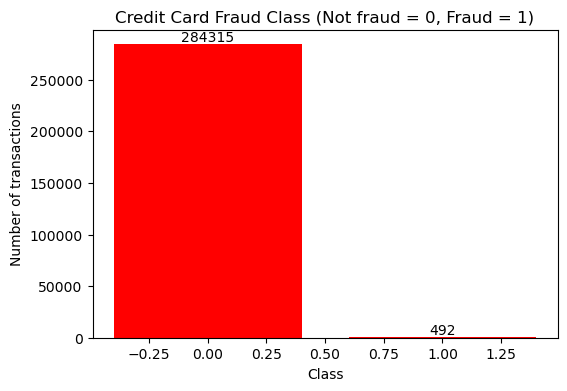

In [8]:
temp = df["Class"].value_counts()
df1 = pd.DataFrame({'Class': temp.index, 'values': temp.values})

temp = df["Class"].value_counts()
df1 = pd.DataFrame({'Class': temp.index, 'values': temp.values})

plt.figure(figsize=(6,4))
plt.bar(df1['Class'], df1['values'], color='red')
plt.title('Credit Card Fraud Class (Not fraud = 0, Fraud = 1)')
plt.xlabel('Class')
plt.ylabel('Number of transactions')

for i, v in enumerate(df1['values']):
    plt.text(df1['Class'][i], v + max(df1['values'])*0.01, str(v), ha='center')

plt.show()

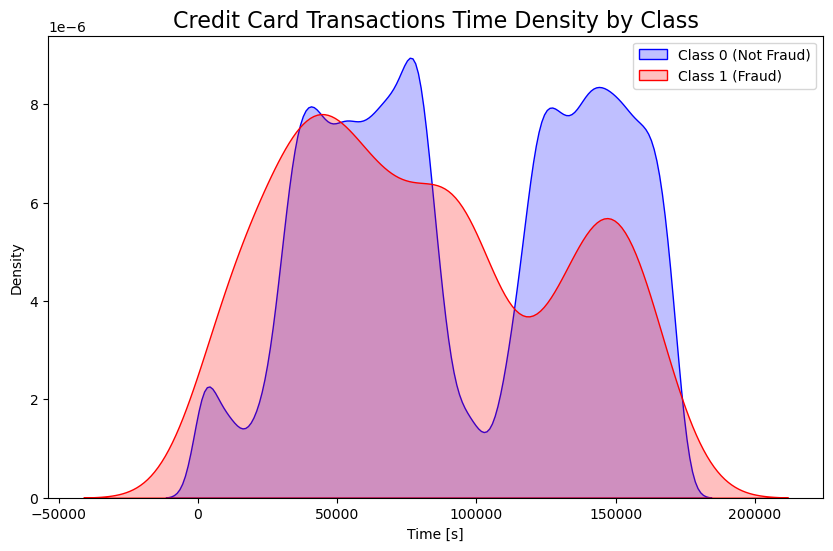

In [9]:
class_0 = df.loc[df['Class'] == 0]["Time"]
class_1 = df.loc[df['Class'] == 1]["Time"]

plt.figure(figsize=(10,6))

sns.kdeplot(x=class_0, fill=True, color='blue', label='Class 0 (Not Fraud)')
sns.kdeplot(x=class_1, fill=True, color='red', label='Class 1 (Fraud)')

plt.xlabel("Time [s]")
plt.ylabel("Density")
plt.title("Credit Card Transactions Time Density by Class", fontsize=16)
plt.legend()
plt.show()

On remarque alors deux choses : la première est la répartition de la variable cible, qui nous montre un dataset déséquilibré ; la deuxième est que la densité des fraudes est assez linéaire, 
tandis que celle des transactions légitimes forme deux pics assez distincts.

# Visualisations

## Impact du montant sur la distinction des classes

Dans cette section, nous allons analyser comment le montant des transactions peut différencier les transactions légitimes (classe 0) des fraudes (classe 1).
Nous examinerons les distributions et les graphiques pour identifier des motifs ou des pics caractéristiques propres à chaque classe, ce qui pourrait être utile pour la détection des fraudes.


In [10]:
df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median']).reset_index()
df2 = pd.DataFrame(tmp)
df2.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median']
display(df2.head())
df2.shape

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900


(94, 8)

In [11]:
stats = ['Min','Mean','Median', 'Max', 'Transactions', 'Sum']

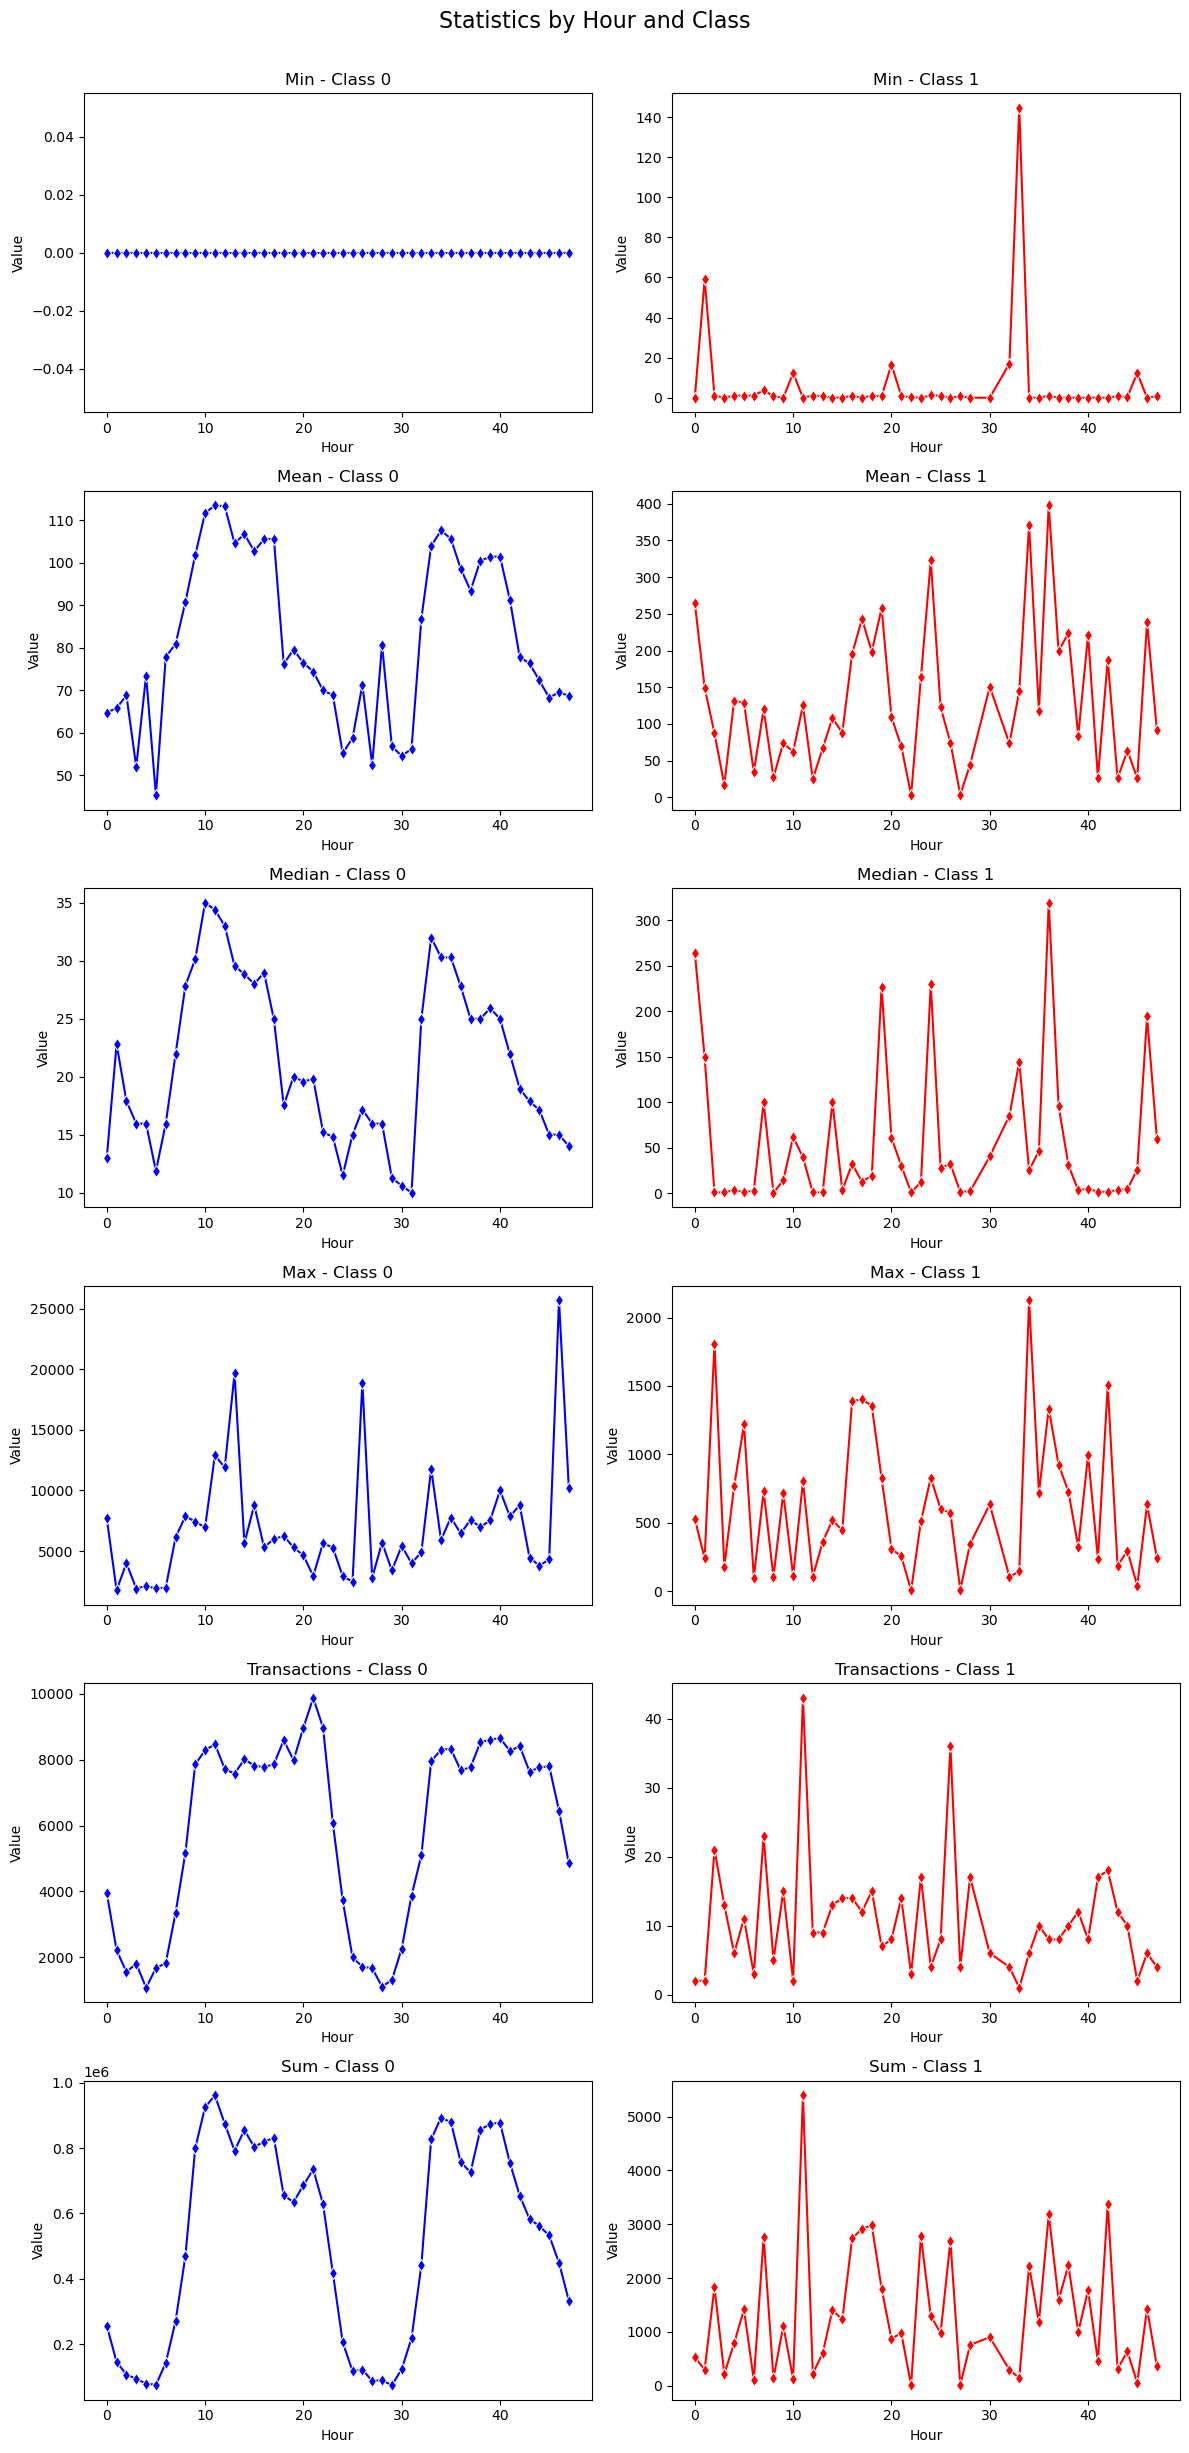

In [12]:
fig, axes = plt.subplots(nrows=len(stats), ncols=2, figsize=(12, 4*len(stats)), sharey=False)

for i, stat in enumerate(stats):
# Classe 0
    sns.lineplot(ax=axes[i,0], x='Hour', y=stat, data=df2[df2.Class==0], marker='d', color='blue')
    axes[i,0].set_title(f"{stat} - Class 0")
    axes[i,0].set_xlabel('Hour')
    axes[i,0].set_ylabel('Value')

# Classe 1
    sns.lineplot(ax=axes[i,1], x='Hour', y=stat, data=df2[df2.Class==1], marker='d', color='red')
    axes[i,1].set_title(f"{stat} - Class 1")
    axes[i,1].set_xlabel('Hour')
    axes[i,1].set_ylabel('Value')

plt.tight_layout()
plt.suptitle("Statistics by Hour and Class", fontsize=16, y=1.02)
plt.show()

On observe une différence entre la classe 0 et la classe 1 : les graphiques de la classe 0 sont assez linéaires, sans pics isolés marqués, 
tandis que ceux de la classe 1 présentent presque uniquement des pics.

## Analyse des distributions des variables par classe

Cette section vise à comparer visuellement la distribution de chaque variable du dataset entre les transactions légitimes (classe 0) et les fraudes (classe 1).

Pour chaque variable, nous traçons une **courbe de densité (KDE)** distincte pour chaque classe :

* La classe 0 est représentée en bleu, montrant le comportement typique des transactions légitimes.
* La classe 1 est représentée en rouge, mettant en évidence les caractéristiques spécifiques des transactions frauduleuses.

Cette visualisation permet d’identifier rapidement quelles variables présentent des différences marquées entre les deux classes et peuvent donc être pertinentes pour la détection de fraude.


<Figure size 640x480 with 0 Axes>

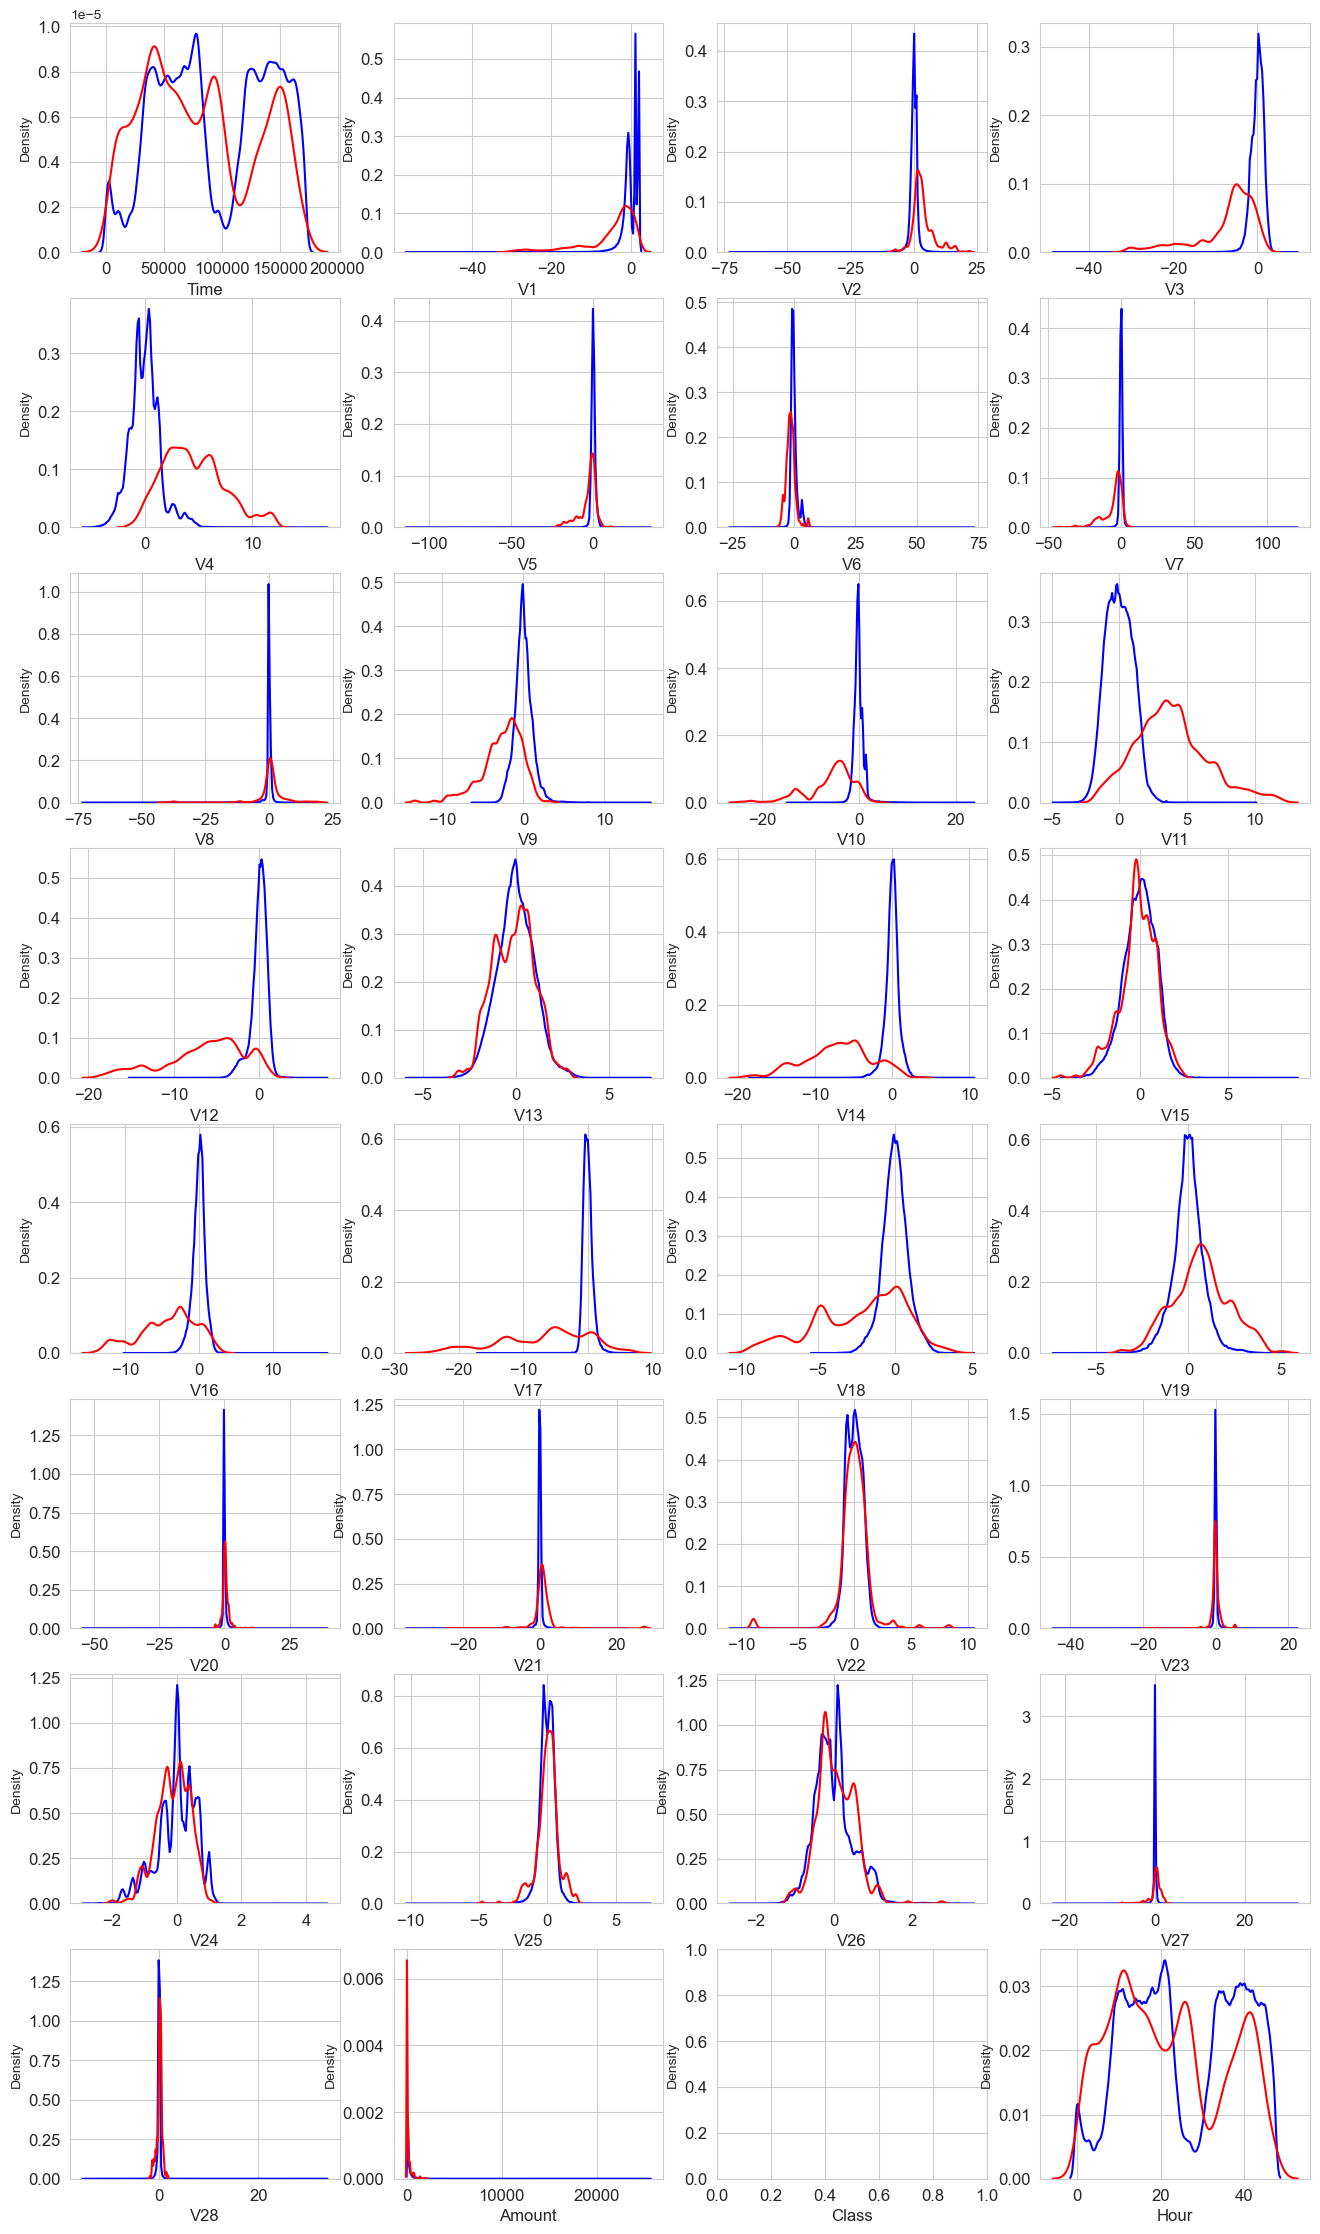

In [13]:
var = df.columns.values

i = 0
t0 = df.loc[df['Class'] == 0]
t1 = df.loc[df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw_adjust=0.5, label="Class = 0", warn_singular=False,color='blue')
    sns.kdeplot(t1[feature], bw_adjust=0.5, label="Class = 1", warn_singular=False,color='red')
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

## Heatmap des corrélations entre variables

Dans cette section, nous visualisons les corrélations entre les différentes variables du dataset à l’aide d’une heatmap.


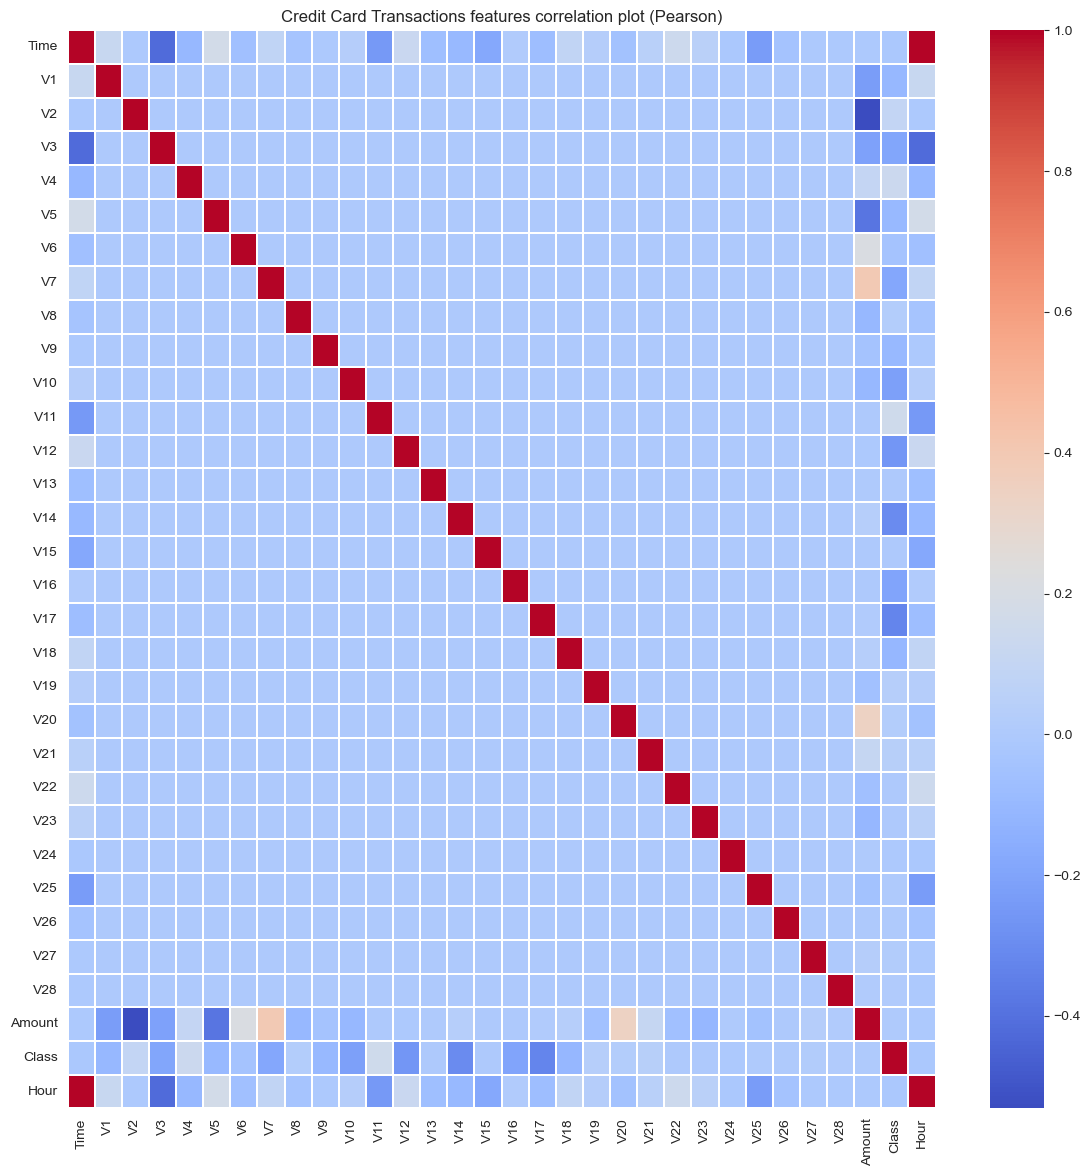

In [14]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="coolwarm")
plt.show()

# Machine Learning

Après avoir exploré et visualisé le dataset, nous passons maintenant à la phase de **machine learning**.

L’objectif est de construire un modèle capable de **prédire si une transaction est légitime (classe 0) ou frauduleuse (classe 1)**.

Cette étape comprend :

* La préparation des données (séparation des variables explicatives et de la variable cible, normalisation si nécessaire)
* La division du dataset en ensembles d’entraînement et de test
* L’entraînement de modèles de classification
* L’évaluation des performances à l’aide de métriques adaptées (précision, rappel, F1-score, AUC, etc.)

Cette démarche permettra de mettre en œuvre un premier modèle prédictif pour la détection de fraudes.


In [15]:
df = pd.read_csv('creditcard.csv')

In [16]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
df['Class'] = df['Class'].map({1: True, 0: False})

In [18]:
scaler = StandardScaler()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = scaler.fit_transform(df[num_cols])

print("✅ Données nettoyées et prêtes pour le Machine Learning !")
display(df.head())

✅ Données nettoyées et prêtes pour le Machine Learning !


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964,False
1,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475,False
2,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686,False
3,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534,False
4,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403,False


In [19]:
X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)
print("Variable cible - distribution :")
print(y.value_counts(normalize=True))

X_train : (227845, 30)
X_test  : (56962, 30)
Variable cible - distribution :
Class
False    0.998273
True     0.001727
Name: proportion, dtype: float64


In [20]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest Classifer": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = []

for name, m in models.items():
    # Entraînement
    m.fit(X_train, y_train)

    # Prédictions
    y_pred = m.predict(X_test)
    y_pred_proba = m.predict_proba(X_test)[:, 1]

    # Scores
    auc = round(roc_auc_score(y_test, y_pred_proba), 3)
    acc = round(accuracy_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)

    results.append((name, acc, f1, auc))

results_df = pd.DataFrame(results,
                          columns=["Modèle", "Accuracy", "F1-score", "ROC"]) \
                          .sort_values(by="ROC", ascending=False)

print("📈 Comparaison des modèles :")
display(results_df)

📈 Comparaison des modèles :


,Modèle,Accuracy,F1-score,ROC
2,Random Forest Classifer,1.000,0.874,0.963
0,Logistic Regression,0.999,0.724,0.960
1,Decision Tree,0.999,0.749,0.872
3,Gradient Boosting,0.998,0.273,0.347


Les résultats des différents modèles de classification montrent que **Random Forest** est le plus performant avec un **F1-score élevé (0.874)** et un **ROC-AUC de 0.963**, ce qui indique une bonne capacité à détecter les fraudes malgré le déséquilibre du dataset.

En revanche, le **Gradient Boosting** obtient des performances très faibles (F1-score = 0.273, ROC-AUC = 0.347), probablement à cause de la **forte rareté des fraudes** dans le dataset, qui rend l’apprentissage plus difficile pour certains modèles.

Les modèles comme la **Logistic Regression** et le **Decision Tree** offrent des performances intermédiaires, mais Random Forest reste le meilleur choix pour ce problème.

On choisit alors de ce concentrer sur le modèle **Random Forest**.

On remarque que dans un dataset désiquilibré, l'acuracy n'est pas très utile pour savoir la puissance du modèle. Un modèle qui ne prédit que des transactions légitimes sera quand même précis même s'il est faux

In [21]:
model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)
print("✅ Modèle entraîné avec succès !")

✅ Modèle entraîné avec succès !


In [22]:
y_pred = model.predict(X_test)

y_pred_classes = (y_pred > 0.5).astype(int)
y_test_classes = (y_test > 0.5).astype(int)

y_true = df["Class"]
y_pred_proba = model.predict_proba(X)[:, 1]
auc = round(roc_auc_score(y_true, y_pred_proba),3)
f1 = round(f1_score(y_test, y_pred),3)
acc = round(accuracy_score(y_test_classes, y_pred_classes), 3)
print("🎯 Accuracy :", acc)
print("F1 score :", f1)
print("ROC :", auc)
print("\n📋 Rapport de classification :\n", classification_report(y_test_classes, y_pred_classes))

🎯 Accuracy : 1.0
F1 score : 0.874
ROC : 0.993

📋 Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



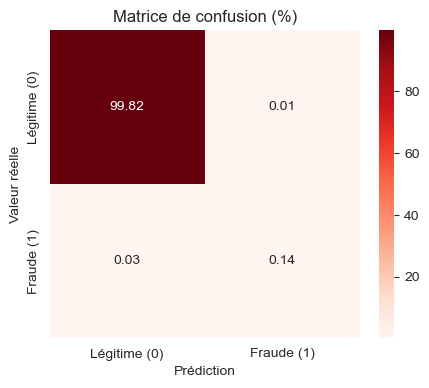

In [24]:
plt.figure(figsize=(5,4))
cm = confusion_matrix(y_test_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum() * 100

labels = ['Légitime (0)', 'Fraude (1)']

sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.title("Matrice de confusion (%)")
plt.xlabel("Prédiction")
plt.ylabel("Valeur réelle")
plt.show()


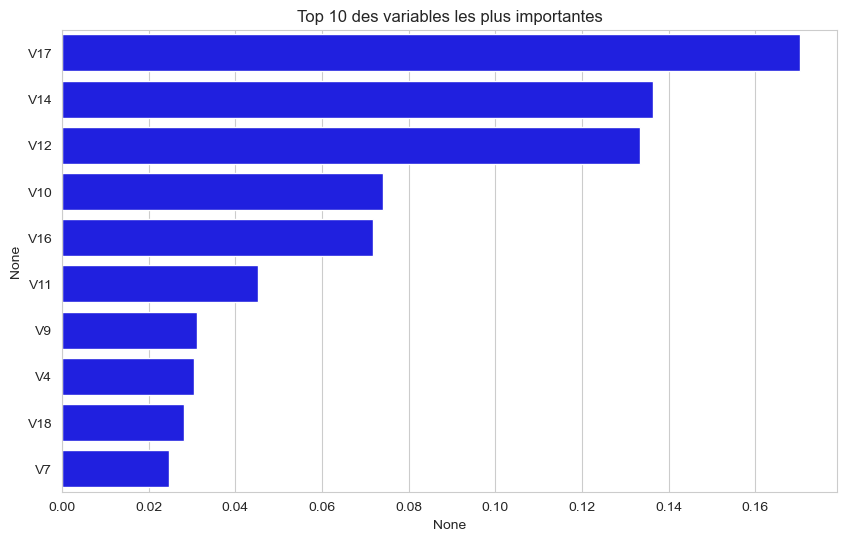

In [25]:
importances = pd.Series(model.feature_importances_, index=X.columns) 
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6)) 
sns.barplot(x=importances[:10], y=importances.index[:10],color = 'blue') 
plt.title("Top 10 des variables les plus importantes") 
plt.show()

Lors de l’analyse du modèle de machine learning, on remarque que les variables **V17, V12 et V14** sont les plus discriminantes pour différencier les transactions légitimes des fraudes.
Les autres variables ont une importance relativement faible, ce qui indique que ces trois composantes principales contiennent l’essentiel de l’information utile pour la détection des fraudes.